In [148]:
# Bibliotecas usadas

import pandas as pd
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

## Caso não possua uma delas, use: pip install NomeDaBiblioteca

### Importando os dados da nossa tabela

In [2]:
file = ('Tabela_QM9_Termodinamica.xlsx')
df = pd.read_excel(file, header=0, usecols=[0, 7, 8, 9])

In [3]:
df.head(5)

,Fórmula,Smiles,Massa Molar (g/mol),Entalpia de Combustão (kcal/mol)
0,CH4,C,16.043,239.315162
1,H3N,N,17.031,0.000000
2,H2O,O,18.015,0.000000
3,C2H2,C#C,26.038,246.164372
4,CHN,C#N,27.026,0.000000


### Normalizando dados

In [4]:
df_treat = df[(df != 0.0000).all(axis=1)]

In [5]:
df_treat_copy = df_treat.copy()

for data in enumerate(df_treat_copy):
    scaler = StandardScaler() # Define a escala padrão de normalização
    #df_treat_copy["Massa normalizada"] = scaler.fit_transform(df_treat_copy[["Massa Molar (g/mol)"]]) # Normaliza os dados da massa
    df_treat_copy["Massa normalizada"] = (df_treat_copy.iloc[:, 2] - df_treat_copy.iloc[:, 2].min()) / (df_treat_copy.iloc[:, 2].max() - df_treat_copy.iloc[:, 2].min()) # Normaliza manualmente

for data in enumerate(df_treat_copy):
    scaler = StandardScaler() # Define a escala padrão de normalização
    #df_treat_copy["Entalpia normalizada"] = scaler.fit_transform(df_treat_copy[["Entalpia de Combustão (kcal/mol)"]]) # Normaliza os dados da combustão
    df_treat_copy["Entalpia normalizada"] = (df_treat_copy.iloc[:, 3] - df_treat_copy.iloc[:, 3].min()) / (df_treat_copy.iloc[:, 3].max() - df_treat_copy.iloc[:, 3].min()) # Normaliza manualmente
df_treat_copy.head(5)

,Fórmula,Smiles,Massa Molar (g/mol),Entalpia de Combustão (kcal/mol),Massa normalizada,Entalpia normalizada
0,CH4,C,16.043,239.315162,0.000000,0.272445
3,C2H2,C#C,26.038,246.164372,0.083220,0.276705
5,CH2O,C=O,30.026,62.878915,0.116424,0.162707
6,C2H6,CC,30.070,385.639048,0.116790,0.363455
7,CH4O,CO,32.042,153.010001,0.133210,0.218766


### Funções Para algoritmo

In [6]:
def gene_combustivel():
    """ Busca aleatória dentro da base de dados um combustivel
    Retorna:
        Um compsoto escolhido aleatóriamente pelo seu índice, nosso gene.
    """
    #fazendo lista dos índices dos nossos compostos
    lista_indices = df_treat_copy.index.tolist()
    # Escolhendo um índice aleatório dentro da lista de índices
    indice_aleatorio = random.choice(lista_indices)
    # indica qual composto corresponde ao indice aleatório escolhido
    # composto = df.loc[indice_aleatorio, 'Smiles']
    composto = indice_aleatorio
    return composto

In [7]:
def individuo_combustivel():
    """Pega dois genes aleatóriamente.
    Retorna:
         Um alista com dois combustiveis
    """
    individuo = []
    for _ in range(2):
        individuo.append(gene_combustivel())
    return individuo

In [8]:
def pop_posto(tamanho):
    """Agrupa os individuos para formar a população de dupla de combustíveis (posto)
    Argumentos:
        tamanho: tamanho da população, quantos individuos a compõe
    Retorna:
        população com número de individuos escolhidos
    """
    posto = []
    for _ in range(tamanho):
        posto.append(individuo_combustivel())
    return posto
    

In [9]:
def selecao_combustivel(populacao, fitness):
    """Seleciona individuos de uma população usando o método da roleta.
    Nota: apenas funciona para problemas de maximização.
    Args:
      populacao: lista com todos os individuos da população
      fitness: lista com o valor da funcao objetivo dos individuos da população
    Returns:
      População dos indivíduos selecionados.
    """
    populacao_selecionada = random.choices(
        populacao, weights=fitness, k=len(populacao)
    )
    return populacao_selecionada

In [112]:
def obj_posto_avaliacao(individuo):
    """ Calcular o fitness do individuo, usando uma função matemática
    Argumentos:
        individuo: lista com dois combustiveis selecionados aleatoriamente
    Retorna:
        O fitness de cada um indivíduo
    """
    # separa os genes dentro do individuo, para avaliar separadamente
    # pega os seus indices
    comb1 = individuo[0]
    comb2 = individuo[1]
    # Pega a informação de entalpia de cada um dos combustiveis
    Hc1 = df_treat_copy.loc[comb1, 'Entalpia normalizada']
    Hc2 = df_treat_copy.loc[comb2, 'Entalpia normalizada']
    #Hc = df.loc[individuo, 'Entalpia de Combustão (kcal/mol)']
    # Pega a massa molar de cada um dos combustiveis
    Mmol1 = df_treat_copy.loc[comb1, 'Massa normalizada']
    Mmol2 = df_treat_copy.loc[comb2, 'Massa normalizada']
    #Mmol = df.loc[individuo, 'Massa Molar (g/mol)']
    
    # Faz função afim para avaliar o valor da entalpia
    y1 = 10*Hc1
    y2 = 0*Hc2
    # y = 2* Hc
    
    # Faz função para avaliar o valor da massa molar
    g1 = -6*Mmol1
    g2 = 4*abs(Mmol1 - Mmol2)
    #g = 1/Mmol
    
    # junta essas informações
    fitness = y1+g1+y2+g2
    #fitness = (y1/Mmol1)+(y2/Mmol2)
    return fitness

In [113]:
def func_obj_pop_posto(populacao):
    """Calcula a funcao objetivo para todos os membros de uma população
    Args:
      populacao: lista com todos os individuos da população
    Return:
      Lista de valores represestando a fitness de cada individuo da população.
    """
    fitness = []
    for individuo in populacao:
        fobj = obj_posto_avaliacao(individuo)
        fitness.append(fobj)
    return fitness

In [114]:
def mutacao_posto(individuo):
    """Muda o valor de um gene por um outro aleatório
    
    Args:
        indidivuo: lista com dois combustiveis selecionados aleatoriamente
        
    Retornos:
        individuo: individuo com um dos genes mutados
    """
    gene_a_ser_mutado = random.randint(0, len(individuo) - 1)
    individuo[gene_a_ser_mutado] = gene_combustivel()
    
    return individuo

In [115]:
def cruzamento_posto(pai, mae):
    """Operador de cruzamento de ponto simples.

    Args:
      pai: uma lista representando um individuo
      mae: uma lista representando um individuo

    Returns:
      Duas listas, sendo que cada uma representa um filho dos pais que foram os
      argumentos.
    """
    ponto_de_corte = random.randint(1, len(pai) - 1)

    filho1 = pai[:ponto_de_corte] + mae[ponto_de_corte:]
    filho2 = mae[:ponto_de_corte] + pai[ponto_de_corte:]

    return filho1, filho2

In [116]:
### CONSTANTES

# relacionadas à busca
TAMANHO_POP = 100
NUM_GERACOES = 200
CHANCE_MUTACAO = 0.05
CHANCE_CRUZAMENTO = 0.5

In [117]:
# função local
def cria_populacao_inicial(TAMANHO_POP):
    return pop_posto(TAMANHO_POP)
def funcao_objetivo_pop(populacao):
    return func_obj_pop_posto(populacao)
def funcao_selecao(populacao, fitness):
    return selecao_combustivel(populacao, fitness)
def funcao_mutacao(individuo):
    return mutacao_posto(individuo)
def funcao_cruzamento(pai, mae):
    return cruzamento_posto(pai, mae)

In [122]:
# Busca por algoritmo genético

populacao = cria_populacao_inicial(TAMANHO_POP)

# variaveis para o hall da fama
melhor_fitness_ja_visto = -float("inf")
melhor_individuo_ja_visto = 0
hall_da_fama = []

for n in range(NUM_GERACOES):

    # Seleção
    fitness = funcao_objetivo_pop(populacao)
    populacao = funcao_selecao(populacao, fitness)
    
    # Cruzamento
    pais = populacao[0::2]
    maes = populacao[1::2]

    contador = 0

    for pai, mae in zip(pais, maes):
        if random.random() <= CHANCE_CRUZAMENTO:
            filho1, filho2 = funcao_cruzamento(pai, mae)
            populacao[contador] = filho1
            populacao[contador + 1] = filho2

        contador = contador + 2

    # Mutação
    for n in range(len(populacao)):
        if random.random() <= CHANCE_MUTACAO:
            individuo = populacao[n]
            populacao[n] = funcao_mutacao(individuo)

    # melhor individuo já visto até agora (hall da fama)
    fitness = funcao_objetivo_pop(populacao)
    maior_fitness = max(fitness)
    posicao = fitness.index(maior_fitness)
    individuo = populacao[posicao].copy()
    
    if maior_fitness > melhor_fitness_ja_visto:
        melhor_fitness_ja_visto = maior_fitness
        melhor_individuo_ja_visto = individuo
        #composto = df.loc[melhor_individuo_ja_visto, 'Smiles']
        #entalpia = df.loc[melhor_individuo_ja_visto, 'Entalpia de Combustão (kcal/mol)']
        #massa = df.loc[melhor_individuo_ja_visto, 'Massa Molar (g/mol)']
        #print(melhor_individuo_ja_visto)
        hall_da_fama.append(melhor_individuo_ja_visto)
        #print(f"Os melhores combustiveis {composto}")
        #print()
        #print(f' massa = {massa} ')
        #print()
        #print(f' entalpia = {entalpia}')
        
print(hall_da_fama)
print()

for i in hall_da_fama:
    print(f'A mistura {i} possui as seguintes características:')
    for j in range(2):
        mol = i[j]
        composto = df_treat_copy.loc[mol, 'Smiles']
        entalpia = df_treat_copy.loc[mol, 'Entalpia de Combustão (kcal/mol)']
        massa = df_treat_copy.loc[mol, 'Massa Molar (g/mol)']
        
        if j == 0: # Combustível Principal
            print(f'O {composto} libera {round(entalpia/massa , 3)} kJ por grama, {massa}')
            
        if j == 1: # Composto a ser descartado
            print(f'O {composto} possui {round(massa, 3)} g/mol')

    print()

[[88945, 1392], [14787, 437], [53, 84477], [53, 96082], [53, 98183]]

A mistura [88945, 1392] possui as seguintes características:
O CC1CC1CC(C)(C)C libera 10.501 kJ por grama, 126.243
O CC#CC(O)C=O possui 98.101 g/mol

A mistura [14787, 437] possui as seguintes características:
O CCCCCCCC libera 10.977 kJ por grama, 114.232
O O=C1CC=CC1 possui 82.102 g/mol

A mistura [53, 84477] possui as seguintes características:
O CC(C)(C)C libera 11.335 kJ por grama, 72.151
O O=CC12C=CC(O)C1C2 possui 124.139 g/mol

A mistura [53, 96082] possui as seguintes características:
O CC(C)(C)C libera 11.335 kJ por grama, 72.151
O CC1OCCC2(C)OC12 possui 128.171 g/mol

A mistura [53, 98183] possui as seguintes características:
O CC(C)(C)C libera 11.335 kJ por grama, 72.151
O CCC(=O)C(C)(C)CO possui 130.187 g/mol



In [149]:
for i in hall_da_fama:
    print(f'A mistura {i} possui as seguintes características:')
    for j in range(2):
        mol = i[j]
        composto = df_treat_copy.loc[mol, 'Smiles']
        entalpia = df_treat_copy.loc[mol, 'Entalpia de Combustão (kcal/mol)']
        massa = df_treat_copy.loc[mol, 'Massa Molar (g/mol)']
        
        if j == 0: # Combustível Principal
            print(f'O {composto} libera {round(entalpia/massa , 3)} kJ por grama com {massa} g/mol')
            
        if j == 1: # Composto a ser descartado
            print(f'O {composto} possui {round(massa, 3)} g/mol')

    print()

A mistura [88945, 1392] possui as seguintes características:
O CC1CC1CC(C)(C)C libera 10.501 kJ por grama com 126.243 g/mol
O CC#CC(O)C=O possui 98.101 g/mol

A mistura [14787, 437] possui as seguintes características:
O CCCCCCCC libera 10.977 kJ por grama com 114.232 g/mol
O O=C1CC=CC1 possui 82.102 g/mol

A mistura [53, 84477] possui as seguintes características:
O CC(C)(C)C libera 11.335 kJ por grama com 72.151 g/mol
O O=CC12C=CC(O)C1C2 possui 124.139 g/mol

A mistura [53, 96082] possui as seguintes características:
O CC(C)(C)C libera 11.335 kJ por grama com 72.151 g/mol
O CC1OCCC2(C)OC12 possui 128.171 g/mol

A mistura [53, 98183] possui as seguintes características:
O CC(C)(C)C libera 11.335 kJ por grama com 72.151 g/mol
O CCC(=O)C(C)(C)CO possui 130.187 g/mol



O combustível (à esquerda) é o 2,2-dimethylpropane e a outra substância (à direita) é o 1-hydroxy-2,2-dimethylpentan-3-one


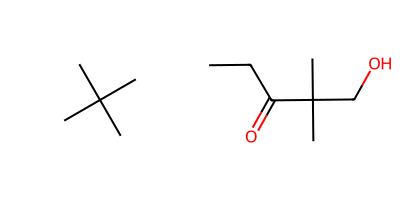

In [160]:
# Buscando o smiles de cada composto na tabela
mol1 = hall_da_fama[len(hall_da_fama) - 1][0]
mol2 = hall_da_fama[len(hall_da_fama) - 1][1]
smiles1 = df_treat_copy.loc[mol1, 'Smiles']
smiles2 = df_treat_copy.loc[mol2, 'Smiles']
coisa1 = Chem.MolFromSmiles(smiles1)
coisa2 = Chem.MolFromSmiles(smiles2)

# Buscando os compostos no pubchem
composto1 = pcp.get_compounds(smiles1, 'smiles')[0]
composto2 = pcp.get_compounds(smiles2, 'smiles')[0]

Nome1 = composto1.iupac_name
Nome2 = composto2.iupac_name

# Exibindo os compostos
print(f"O combustível (à esquerda) é o {Nome1} e a outra substância (à direita) é o {Nome2}")
Draw.MolsToGridImage([coisa1,coisa2], molsPerRow=2)